# 2. Import libraries and read data

In [1]:
import joblib
import optuna
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import optuna.visualization as vis


# 4. Modeling

## 4.1 Model preparation

### 4.1.1 Train-Test Split

In [2]:
from joblib import Parallel, delayed
from joblib import parallel_backend

In [3]:
df = pd.read_csv("data_resampled_10.csv")

### 4.1.3 Cross Vallidation

In [4]:
majority_class = df[df['Outcome'] == 0]
minority_class = df[df['Outcome'] == 1]

# Define the number of samples to select
n_samples = 50

# Perform random sampling
sampled_majority = majority_class.sample(n_samples, random_state=123)
sampled_minority = minority_class.sample(n_samples, random_state=123)

# Combine sampled data
sampled_df = pd.concat([sampled_majority, sampled_minority])
sampled_df

#test
y_test = sampled_df['Outcome']
x_test = sampled_df.drop(columns='Outcome')

# train
# Separate remaining data for training
remaining_df = df.drop(sampled_df.index)
y_train = remaining_df['Outcome']
x_train= remaining_df.drop(columns='Outcome')

scaler = StandardScaler()
scaler.fit(x_train)

x_train_ = scaler.transform(x_train)
x_test_ = scaler.transform(x_test)

In [5]:
#from sklearn.model_selection import RepeatedKFold
rs=123
cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=345)

## Basic Structure of an Optuna Optimization Script

The overall process works differently from the brute-force approach of GridSearchCV. Because of this, let's cover off the different components of the process:

1. Defining the objective function
2. Creating a Study Object
3. Running the Optimization Process

The objective function is at the core of how Optuna optimizes the hyperparameter selections. While a brute-force grid search also seeks to minimize an objective function, it doesn't actually take into account what combination of hyperparameters is doing well or not.

## 4.2 KNN (K-Nearest Neighbors Algorithm)

In [6]:
# Creating an Objective Function

def objective_knn(trial):
    
    # Define hyperparameters
    param_knn = {'n_neighbors' : trial.suggest_int('n_neighbors', 1, 100)
    ,'weights' : trial.suggest_categorical('weights', ['uniform', 'distance']),
    'metric' : trial.suggest_categorical('metric', ['euclidean', 'manhattan','minkowski']),
    'p' : trial.suggest_int('p', 1, 50),
    'algorithm' : trial.suggest_categorical('algorithm',['auto','ball_tree', 'kd_tree', 'brute']),
    'leaf_size' : trial.suggest_int('leaf_size', 1, 100)}

    # Create and train the model
    knn = KNeighborsClassifier(**param_knn)
    knn.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(knn, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [7]:
# Creating and running our optimization
study_knn = optuna.create_study(direction='maximize',study_name = "KNN")
study_knn.optimize(objective_knn, n_trials=100)

[I 2024-08-26 01:40:56,747] A new study created in memory with name: KNN
[I 2024-08-26 01:40:57,751] Trial 0 finished with value: 0.502364034195632 and parameters: {'n_neighbors': 69, 'weights': 'distance', 'metric': 'manhattan', 'p': 20, 'algorithm': 'kd_tree', 'leaf_size': 27}. Best is trial 0 with value: 0.502364034195632.
[I 2024-08-26 01:40:58,512] Trial 1 finished with value: 0.5294677231563122 and parameters: {'n_neighbors': 33, 'weights': 'uniform', 'metric': 'euclidean', 'p': 36, 'algorithm': 'ball_tree', 'leaf_size': 78}. Best is trial 1 with value: 0.5294677231563122.
[I 2024-08-26 01:40:59,174] Trial 2 finished with value: 0.5648123823364884 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'metric': 'euclidean', 'p': 19, 'algorithm': 'ball_tree', 'leaf_size': 34}. Best is trial 2 with value: 0.5648123823364884.
[I 2024-08-26 01:40:59,753] Trial 3 finished with value: 0.602904343148598 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'metric': 'euclidean', 

[I 2024-08-26 01:41:34,918] Trial 32 finished with value: 0.8086719882298463 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean', 'p': 41, 'algorithm': 'brute', 'leaf_size': 80}. Best is trial 15 with value: 0.8265675965903501.
[I 2024-08-26 01:41:35,358] Trial 33 finished with value: 0.6911547662250206 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean', 'p': 36, 'algorithm': 'brute', 'leaf_size': 94}. Best is trial 15 with value: 0.8265675965903501.
[I 2024-08-26 01:41:35,982] Trial 34 finished with value: 0.8086719882298463 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean', 'p': 39, 'algorithm': 'ball_tree', 'leaf_size': 82}. Best is trial 15 with value: 0.8265675965903501.
[I 2024-08-26 01:41:37,038] Trial 35 finished with value: 0.5997034431811162 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'metric': 'euclidean', 'p': 45, 'algorithm': 'brute', 'leaf_size': 90}. Best is trial 15 wit

[I 2024-08-26 01:41:53,722] Trial 64 finished with value: 0.7319947052607558 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'p': 44, 'algorithm': 'brute', 'leaf_size': 95}. Best is trial 15 with value: 0.8265675965903501.
[I 2024-08-26 01:41:54,184] Trial 65 finished with value: 0.7930579752573443 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'brute', 'leaf_size': 100}. Best is trial 15 with value: 0.8265675965903501.
[I 2024-08-26 01:41:54,730] Trial 66 finished with value: 0.6857589800941726 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'metric': 'manhattan', 'p': 41, 'algorithm': 'brute', 'leaf_size': 68}. Best is trial 15 with value: 0.8265675965903501.
[I 2024-08-26 01:41:54,993] Trial 67 finished with value: 0.8265675965903501 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan', 'p': 50, 'algorithm': 'kd_tree', 'leaf_size': 87}. Best is trial 15 wit

[I 2024-08-26 01:42:07,009] Trial 96 finished with value: 0.748988392401511 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'p': 47, 'algorithm': 'auto', 'leaf_size': 94}. Best is trial 15 with value: 0.8265675965903501.
[I 2024-08-26 01:42:07,766] Trial 97 finished with value: 0.48066769967765394 and parameters: {'n_neighbors': 100, 'weights': 'distance', 'metric': 'manhattan', 'p': 42, 'algorithm': 'kd_tree', 'leaf_size': 89}. Best is trial 15 with value: 0.8265675965903501.
[I 2024-08-26 01:42:08,363] Trial 98 finished with value: 0.8265675965903501 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan', 'p': 49, 'algorithm': 'ball_tree', 'leaf_size': 80}. Best is trial 15 with value: 0.8265675965903501.
[I 2024-08-26 01:42:09,066] Trial 99 finished with value: 0.722467753998641 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'metric': 'manhattan', 'p': 46, 'algorithm': 'kd_tree', 'leaf_size': 83}. Best is trial 15 

In [8]:
# Evaluating our Optuna Trial
print("Best trial:", study_knn.best_trial.number)
print("Best accuracy:", study_knn.best_trial.value)
print("Best hyperparameters:", study_knn.best_params)

Best trial: 15
Best accuracy: 0.8265675965903501
Best hyperparameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan', 'p': 35, 'algorithm': 'brute', 'leaf_size': 77}


              precision    recall  f1-score   support

           0     0.7042    1.0000    0.8264        50
           1     1.0000    0.5800    0.7342        50

    accuracy                         0.7900       100
   macro avg     0.8521    0.7900    0.7803       100
weighted avg     0.8521    0.7900    0.7803       100



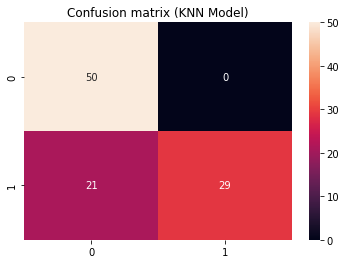

In [36]:
best_param_knn = study_knn.best_params
KNN = KNeighborsClassifier(**best_param_knn).fit(x_train_,y_train)
y_pred_knn = KNN.predict(x_test_)

def display_results(y_test, y_pred, cm_title):
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
    print(classification_report(y_test,y_pred, digits=4))
    
display_results(y_test, y_pred_knn, cm_title = "Confusion matrix (KNN Model)")

Accuracy: 0.7900
Precision: 1.0000
Recall: 0.5800
F1 Score: 0.7342

Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.83        50
           1       1.00      0.58      0.73        50

    accuracy                           0.79       100
   macro avg       0.85      0.79      0.78       100
weighted avg       0.85      0.79      0.78       100



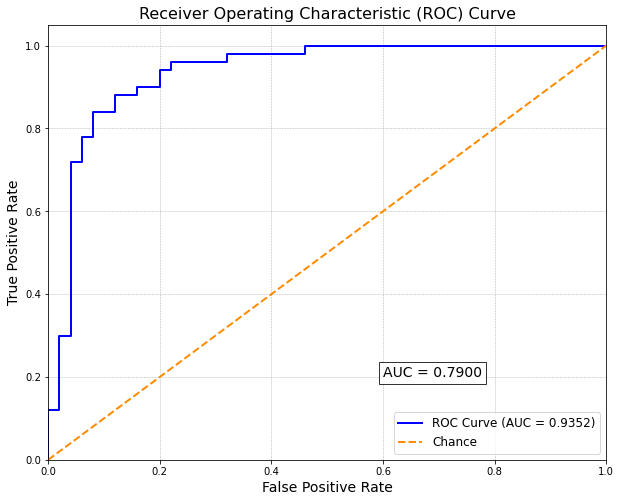

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, classification_report

# Get the best parameters from the Optuna study and train the KNN model
best_knn = KNeighborsClassifier(**study_knn.best_params)
best_knn.fit(x_train_, y_train)

# Predict on the test set
y_pred = best_knn.predict(x_test_)
y_proba = best_knn.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_knn = accuracy_score(y_test, y_pred)
precision_knn = precision_score(y_test, y_pred)
recall_knn = recall_score(y_test, y_pred)
f1_knn = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot the ROC curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_lr:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Annotate AUC directly on the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc_knn:.4f}', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()


## 4.3 Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def objective_lr(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }

    # Define hyperparameters
    param_logr = {
        'C': trial.suggest_float("C", 0.001, 10.0, log=True),
        'solver': trial.suggest_categorical('solver', ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]),
        'max_iter': trial.suggest_int("max_iter", 50, 1000),
        'class_weight': class_weight  # Apply custom class weights
    }

    # Create and train the model
    lr = LogisticRegression(**param_logr, random_state=42)
    
    # Evaluate the model using cross-validation with the f1_macro score to handle imbalance
    score = cross_val_score(lr, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score



In [12]:
# Creating and running our optimization

study_lr = optuna.create_study(direction='maximize',study_name = "logr")
study_lr.optimize(objective_lr, n_trials=100)

[I 2024-08-26 01:42:09,320] A new study created in memory with name: logr
[I 2024-08-26 01:42:11,906] Trial 0 finished with value: 0.6308986978429746 and parameters: {'C': 0.030883632898505698, 'solver': 'newton-cg', 'max_iter': 330}. Best is trial 0 with value: 0.6308986978429746.
[I 2024-08-26 01:42:13,961] Trial 1 finished with value: 0.4801287825471773 and parameters: {'C': 0.012116315976520173, 'solver': 'sag', 'max_iter': 182}. Best is trial 0 with value: 0.6308986978429746.
[I 2024-08-26 01:42:21,573] Trial 2 finished with value: 0.6307468016616293 and parameters: {'C': 1.6077733694562433, 'solver': 'newton-cg', 'max_iter': 713}. Best is trial 0 with value: 0.6308986978429746.
[I 2024-08-26 01:42:25,882] Trial 3 finished with value: 0.6309177853464063 and parameters: {'C': 3.996637925909344, 'solver': 'newton-cg', 'max_iter': 377}. Best is trial 3 with value: 0.6309177853464063.
[I 2024-08-26 01:42:29,789] Trial 4 finished with value: 0.4876945248088978 and parameters: {'C': 0.9

[I 2024-08-26 01:44:59,666] Trial 40 finished with value: 0.5341918064029615 and parameters: {'C': 0.3628226818730145, 'solver': 'sag', 'max_iter': 818}. Best is trial 17 with value: 0.6319769987389805.
[I 2024-08-26 01:45:05,395] Trial 41 finished with value: 0.6319930354686162 and parameters: {'C': 0.10830025910523321, 'solver': 'newton-cg', 'max_iter': 757}. Best is trial 41 with value: 0.6319930354686162.
[I 2024-08-26 01:45:10,351] Trial 42 finished with value: 0.6319523536492191 and parameters: {'C': 0.07163886195416776, 'solver': 'newton-cg', 'max_iter': 748}. Best is trial 41 with value: 0.6319930354686162.
[I 2024-08-26 01:45:15,273] Trial 43 finished with value: 0.6318763701653662 and parameters: {'C': 0.06716920965570497, 'solver': 'newton-cg', 'max_iter': 582}. Best is trial 41 with value: 0.6319930354686162.
[I 2024-08-26 01:45:20,353] Trial 44 finished with value: 0.6299780531459397 and parameters: {'C': 0.02262035722521573, 'solver': 'newton-cg', 'max_iter': 759}. Best i

[I 2024-08-26 01:47:55,079] Trial 80 finished with value: 0.6317668704180693 and parameters: {'C': 0.1138605608660265, 'solver': 'newton-cg', 'max_iter': 686}. Best is trial 52 with value: 0.6320028887056479.
[I 2024-08-26 01:47:58,959] Trial 81 finished with value: 0.6317480326192955 and parameters: {'C': 0.056063668343904534, 'solver': 'newton-cg', 'max_iter': 742}. Best is trial 52 with value: 0.6320028887056479.
[I 2024-08-26 01:48:03,258] Trial 82 finished with value: 0.6279797582016288 and parameters: {'C': 0.012737055935670321, 'solver': 'newton-cg', 'max_iter': 729}. Best is trial 52 with value: 0.6320028887056479.
[I 2024-08-26 01:48:07,366] Trial 83 finished with value: 0.6301234505923106 and parameters: {'C': 0.02490441103354913, 'solver': 'newton-cg', 'max_iter': 858}. Best is trial 52 with value: 0.6320028887056479.
[I 2024-08-26 01:48:11,285] Trial 84 finished with value: 0.6320777610487331 and parameters: {'C': 0.0625190672234468, 'solver': 'newton-cg', 'max_iter': 516}.

In [13]:
# Evaluating our Optuna Trial
print("Best trial:", study_lr.best_trial.number)
print("Best accuracy:", study_lr.best_trial.value)
print("Best hyperparameters:", study_lr.best_params)

Best trial: 84
Best accuracy: 0.6320777610487331
Best hyperparameters: {'C': 0.0625190672234468, 'solver': 'newton-cg', 'max_iter': 516}


              precision    recall  f1-score   support

           0       0.56      0.98      0.72        50
           1       0.92      0.24      0.38        50

    accuracy                           0.61       100
   macro avg       0.74      0.61      0.55       100
weighted avg       0.74      0.61      0.55       100



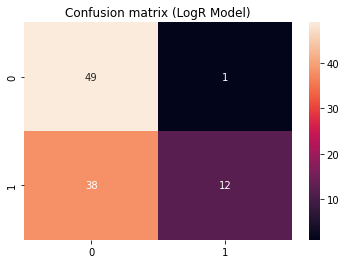

In [14]:
best_param_logr = study_lr.best_params
LR = LogisticRegression(**best_param_logr).fit(x_train_,y_train)
y_pred_lr = LR.predict(x_test_)
    
display_results(y_test, y_pred_lr, cm_title = "Confusion matrix (LogR Model)")

Accuracy: 0.6100
Precision: 0.9231
Recall: 0.2400
F1 Score: 0.3810

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.98      0.72        50
           1       0.92      0.24      0.38        50

    accuracy                           0.61       100
   macro avg       0.74      0.61      0.55       100
weighted avg       0.74      0.61      0.55       100



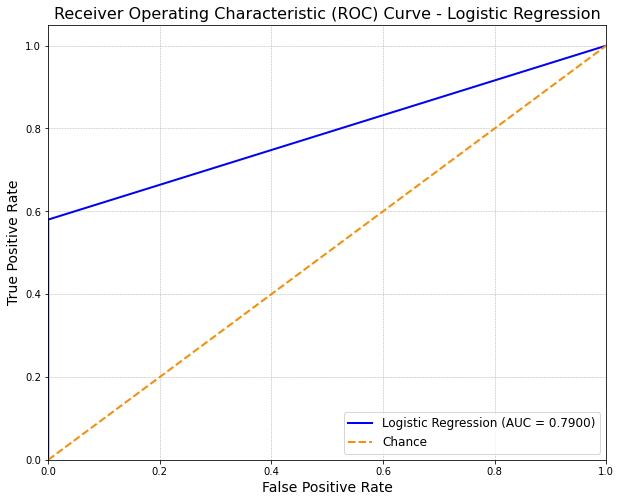

In [56]:
# Predict on the test set
y_pred_lr = LR.predict(x_test_)
y_proba_lr = LR.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Plot the ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(10, 8))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_knn:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)


# Show the plot
plt.show()

## 4.4 Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

def objective_dect(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_dect = {
        'max_depth' : trial.suggest_int("max_depth", 2, 64),
        'ccp_alpha' : trial.suggest_float('ccp_alpha', 0.001, 10.0, log=True),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_split' : trial.suggest_int("min_samples_split", 2, 30),
        'min_samples_leaf' : trial.suggest_int("min_samples_leaf", 1, 30),
        'criterion' : trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'class_weight': class_weight
    }

    # Create and train the model
    dect = DecisionTreeClassifier(**param_dect, random_state=123)
    dect.fit(x_train, y_train)

    # Evaluate the model
    score = cross_val_score(dect, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [17]:
# Creating and running our optimization

study_dect = optuna.create_study(direction='maximize',study_name = "Dect")
study_dect.optimize(objective_dect, n_trials=100)

[I 2024-08-26 01:49:09,488] A new study created in memory with name: Dect
[I 2024-08-26 01:49:09,740] Trial 0 finished with value: 0.6669649215874229 and parameters: {'max_depth': 58, 'ccp_alpha': 0.07097364570842234, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.6669649215874229.
[I 2024-08-26 01:49:09,956] Trial 1 finished with value: 0.23396318737470045 and parameters: {'max_depth': 16, 'ccp_alpha': 0.3938847985040037, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 0 with value: 0.6669649215874229.
[I 2024-08-26 01:49:10,191] Trial 2 finished with value: 0.6809792404516667 and parameters: {'max_depth': 55, 'ccp_alpha': 0.010789680195552044, 'max_features': 'auto', 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 2 with value: 0.6809792404516667.
[I 2024-08-26 01:49:10,457] Trial 3 finished with value: 0.23396318

[I 2024-08-26 01:49:17,070] Trial 28 finished with value: 0.6669649215874229 and parameters: {'max_depth': 50, 'ccp_alpha': 0.13966339353279356, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 27 with value: 0.713469990441766.
[I 2024-08-26 01:49:17,330] Trial 29 finished with value: 0.7134286237087442 and parameters: {'max_depth': 58, 'ccp_alpha': 0.0018550901377276823, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 27 with value: 0.713469990441766.
[I 2024-08-26 01:49:17,601] Trial 30 finished with value: 0.6883577371394114 and parameters: {'max_depth': 57, 'ccp_alpha': 0.008123795034427138, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 27 with value: 0.713469990441766.
[I 2024-08-26 01:49:17,871] Trial 31 finished with value: 0.704517368647493 and parameters: {'max_depth': 58, 'ccp_alpha': 0.0021

[I 2024-08-26 01:49:24,981] Trial 57 finished with value: 0.7478419370268532 and parameters: {'max_depth': 10, 'ccp_alpha': 0.0014465130787313795, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 47 with value: 0.8079490280871032.
[I 2024-08-26 01:49:25,253] Trial 58 finished with value: 0.6922559457015945 and parameters: {'max_depth': 24, 'ccp_alpha': 0.005458668099580351, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 47 with value: 0.8079490280871032.
[I 2024-08-26 01:49:25,519] Trial 59 finished with value: 0.7168639772937544 and parameters: {'max_depth': 8, 'ccp_alpha': 0.0038939842180584685, 'max_features': 'log2', 'min_samples_split': 21, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 47 with value: 0.8079490280871032.
[I 2024-08-26 01:49:25,797] Trial 60 finished with value: 0.7557005391636615 and parameters: {'max_depth': 15, 'ccp_alpha': 0.0014129

[I 2024-08-26 01:49:33,083] Trial 86 finished with value: 0.6669649215874229 and parameters: {'max_depth': 41, 'ccp_alpha': 0.06808393854462207, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 47 with value: 0.8079490280871032.
[I 2024-08-26 01:49:33,387] Trial 87 finished with value: 0.7574242233221312 and parameters: {'max_depth': 56, 'ccp_alpha': 0.0012301093548883679, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 47 with value: 0.8079490280871032.
[I 2024-08-26 01:49:33,660] Trial 88 finished with value: 0.7552141419730893 and parameters: {'max_depth': 16, 'ccp_alpha': 0.0020738816373438353, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 47 with value: 0.8079490280871032.
[I 2024-08-26 01:49:33,974] Trial 89 finished with value: 0.811859790188401 and parameters: {'max_depth': 60, 'ccp_alpha': 0.0

In [18]:
# Evaluating our Optuna Trial
print("Best trial:", study_dect.best_trial.number)
print("Best accuracy:", study_dect.best_trial.value)
print("Best hyperparameters:", study_dect.best_params)

Best trial: 90
Best accuracy: 0.8122735308555825
Best hyperparameters: {'max_depth': 44, 'ccp_alpha': 0.0016203326503204417, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'entropy'}


              precision    recall  f1-score   support

           0       0.80      0.98      0.88        50
           1       0.97      0.76      0.85        50

    accuracy                           0.87       100
   macro avg       0.89      0.87      0.87       100
weighted avg       0.89      0.87      0.87       100



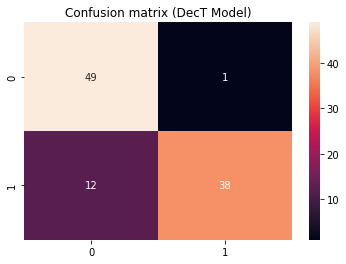

In [19]:
best_param_dect = study_dect.best_params
DecT = DecisionTreeClassifier(**best_param_dect,random_state=42).fit(x_train,y_train)
y_pred_dect = DecT.predict(x_test)
    

display_results(y_test, y_pred_dect, cm_title = "Confusion matrix (DecT Model)")

Accuracy: 0.9000
Precision: 0.9762
Recall: 0.8200
F1 Score: 0.8913

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.91        50
           1       0.98      0.82      0.89        50

    accuracy                           0.90       100
   macro avg       0.91      0.90      0.90       100
weighted avg       0.91      0.90      0.90       100



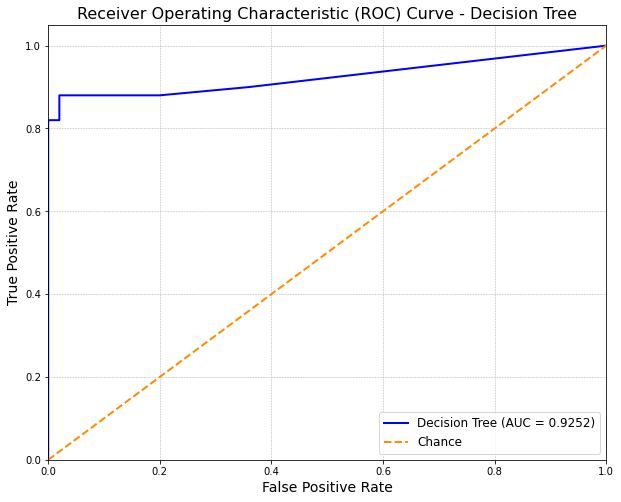

In [20]:
# Train the best Decision Tree model
best_param_dect = study_dect.best_params
best_dect = DecisionTreeClassifier(**best_param_dect, random_state=123)
best_dect.fit(x_train_, y_train)

# Predict on the test set
y_pred_dect = best_dect.predict(x_test_)
y_proba_dect = best_dect.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_dect = accuracy_score(y_test, y_pred_dect)
precision_dect = precision_score(y_test, y_pred_dect)
recall_dect = recall_score(y_test, y_pred_dect)
f1_dect = f1_score(y_test, y_pred_dect)

print(f"Accuracy: {accuracy_dect:.4f}")
print(f"Precision: {precision_dect:.4f}")
print(f"Recall: {recall_dect:.4f}")
print(f"F1 Score: {f1_dect:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dect))

# Plot the ROC curve
fpr_dect, tpr_dect, _ = roc_curve(y_test, y_proba_dect)
roc_auc_dect = auc(fpr_dect, tpr_dect)

plt.figure(figsize=(10, 8))
plt.plot(fpr_dect, tpr_dect, color='blue', lw=2, label=f'Decision Tree (AUC = {roc_auc_dect:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - Decision Tree', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)


# Show the plot
plt.show()

## 4.5 SVM (Support Vector Machine)

In [21]:
# Creating an Objective Function

def objective_svm(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
                'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0),
                'class_weight': class_weight
                }

    # Create and train the model
    svm = SVC(**param_svm,random_state=rs)
    svm.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(svm, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [22]:
# Creating and running our optimization

study_svm = optuna.create_study(direction='maximize',study_name ="SVM")
study_svm.optimize(objective_svm, n_trials=100)

[I 2024-08-26 01:49:37,505] A new study created in memory with name: SVM
[I 2024-08-26 01:49:56,054] Trial 0 finished with value: 0.5345027593372405 and parameters: {'C': 0.004651960027524897, 'gamma': 0.1622071407205815}. Best is trial 0 with value: 0.5345027593372405.
[I 2024-08-26 01:50:16,186] Trial 1 finished with value: 0.6010509469990043 and parameters: {'C': 0.005822966337220207, 'gamma': 0.005108767658446901}. Best is trial 1 with value: 0.6010509469990043.
[I 2024-08-26 01:50:26,732] Trial 2 finished with value: 0.6928849153386678 and parameters: {'C': 113.22053028774799, 'gamma': 0.0027129142283965533}. Best is trial 2 with value: 0.6928849153386678.
[I 2024-08-26 01:50:39,641] Trial 3 finished with value: 0.638206144284995 and parameters: {'C': 0.016187467919149504, 'gamma': 0.06759034838075505}. Best is trial 2 with value: 0.6928849153386678.
[I 2024-08-26 01:50:59,624] Trial 4 finished with value: 0.23396318737470045 and parameters: {'C': 0.0034456557516610933, 'gamma': 1

[I 2024-08-26 01:56:12,532] Trial 41 finished with value: 0.7926439760937392 and parameters: {'C': 150.44279147484616, 'gamma': 0.04425561968267284}. Best is trial 40 with value: 0.8492702018004159.
[I 2024-08-26 01:56:16,674] Trial 42 finished with value: 0.849428669179633 and parameters: {'C': 67.77435540929567, 'gamma': 0.21109905724555578}. Best is trial 42 with value: 0.849428669179633.
[I 2024-08-26 01:56:20,634] Trial 43 finished with value: 0.8518887755138196 and parameters: {'C': 90.00998256827971, 'gamma': 0.18797895405880335}. Best is trial 43 with value: 0.8518887755138196.
[I 2024-08-26 01:56:24,580] Trial 44 finished with value: 0.8491438017242724 and parameters: {'C': 74.86582322874729, 'gamma': 0.1793366263298495}. Best is trial 43 with value: 0.8518887755138196.
[I 2024-08-26 01:56:37,407] Trial 45 finished with value: 0.7713625799603974 and parameters: {'C': 241.72056326866016, 'gamma': 0.02203345033347171}. Best is trial 43 with value: 0.8518887755138196.
[I 2024-08-

[I 2024-08-26 02:00:26,199] Trial 83 finished with value: 0.8393376059840644 and parameters: {'C': 9.428149614978084, 'gamma': 0.3494312520550239}. Best is trial 80 with value: 0.8523600615867306.
[I 2024-08-26 02:00:30,301] Trial 84 finished with value: 0.8489537476546496 and parameters: {'C': 23.851557504918755, 'gamma': 0.22587304803697977}. Best is trial 80 with value: 0.8523600615867306.
[I 2024-08-26 02:00:37,031] Trial 85 finished with value: 0.7697350158253441 and parameters: {'C': 2.2779367823122043, 'gamma': 0.08228948123810331}. Best is trial 80 with value: 0.8523600615867306.
[I 2024-08-26 02:00:57,052] Trial 86 finished with value: 0.24297949123676404 and parameters: {'C': 0.001210179827261951, 'gamma': 0.15514427282248916}. Best is trial 80 with value: 0.8523600615867306.
[I 2024-08-26 02:01:03,364] Trial 87 finished with value: 0.7773987175888475 and parameters: {'C': 13.302490083346, 'gamma': 0.5591263470308128}. Best is trial 80 with value: 0.8523600615867306.
[I 2024-

In [23]:
# Evaluating our Optuna Trial
print("Best trial:", study_svm.best_trial.number)
print("Best accuracy:", study_svm.best_trial.value)
print("Best hyperparameters:", study_svm.best_params)

Best trial: 80
Best accuracy: 0.8523600615867306
Best hyperparameters: {'C': 8.556982174186126, 'gamma': 0.2270662043270127}


              precision    recall  f1-score   support

           0       0.72      1.00      0.84        50
           1       1.00      0.62      0.77        50

    accuracy                           0.81       100
   macro avg       0.86      0.81      0.80       100
weighted avg       0.86      0.81      0.80       100



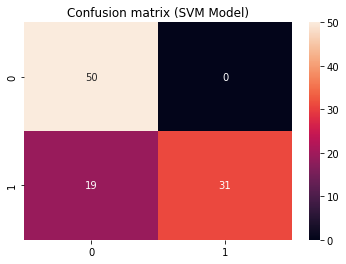

In [24]:
best_param_svm = study_svm.best_params
SVM = SVC(**best_param_svm,random_state=rs).fit(x_train_,y_train)
y_pred_svm = SVM.predict(x_test_)

display_results(y_test, y_pred_svm, cm_title = "Confusion matrix (SVM Model)")

Accuracy: 0.8100
Precision: 1.0000
Recall: 0.6200
F1 Score: 0.7654

Classification Report:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        50
           1       1.00      0.62      0.77        50

    accuracy                           0.81       100
   macro avg       0.86      0.81      0.80       100
weighted avg       0.86      0.81      0.80       100



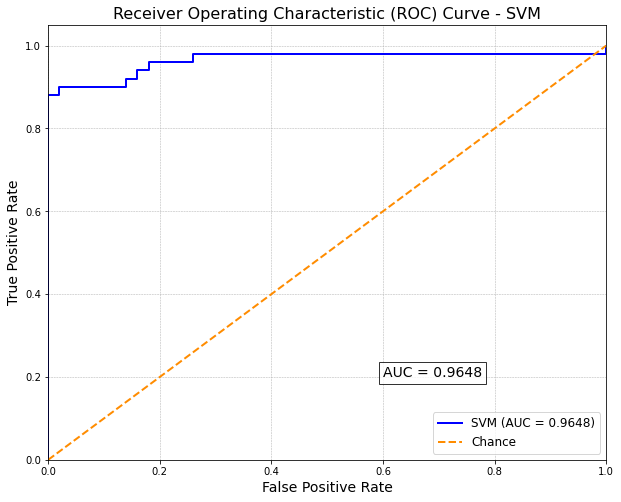

In [25]:
# Train the best SVM model
best_param_svm = study_svm.best_params
best_svm = SVC(**best_param_svm, random_state=123, probability=True)
best_svm.fit(x_train_, y_train)

# Predict on the test set
y_pred_svm = best_svm.predict(x_test_)
y_proba_svm = best_svm.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1 Score: {f1_svm:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

# Plot the ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label=f'SVM (AUC = {roc_auc_svm:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Annotate AUC directly on the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc_svm:.4f}', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()

## Xgboost

In [26]:
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score

def objective_xgb(trial: optuna.Trial):
    # Assume the data is already split into x_train_ and y_train_
    n_minority = y_train.sum()  # Number of minority class instances (assume minority class is '1')
    n_majority = len(y_train) - n_minority  # Number of majority class instances (assume majority class is '0')
    
    # Calculate scale_pos_weight
    scale_pos_weight = n_majority / n_minority
    
    # Define hyperparameters
    param_xgb = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': 0.1,  # Fixed at 0.1 as per your instructions
        'n_estimators': 200,  # Fixed at 200
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1e1),
        'scale_pos_weight': scale_pos_weight  # Calculated to handle class imbalance
    }

    # Create and evaluate the XGBoost model
    xgb_model = xgb.XGBClassifier(**param_xgb, use_label_encoder=False, eval_metric='logloss', random_state=123)
    score = cross_val_score(xgb_model, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

# Example usage:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective_xgb, n_trials=100)


In [27]:
pos_weight = y_train.sum() / (len(y_train) - y_train.sum())
pos_weight

0.08029197080291971

In [28]:
# Creating and running our optimization
study_xgb = optuna.create_study(direction='maximize', study_name="XGBoost")

with parallel_backend('threading'):
    study_xgb.optimize(objective_xgb, n_trials=20, n_jobs=-1)

[I 2024-08-26 02:02:22,822] A new study created in memory with name: XGBoost
[I 2024-08-26 02:03:29,687] Trial 0 finished with value: 0.8589476816277213 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.7672404048823028, 'colsample_bytree': 0.5076315739620852, 'reg_alpha': 0.039865420453550335, 'reg_lambda': 0.4815448063320807}. Best is trial 0 with value: 0.8589476816277213.
[I 2024-08-26 02:03:29,813] Trial 7 finished with value: 0.8534203424868239 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.5341304864439358, 'colsample_bytree': 0.5064949016696549, 'reg_alpha': 0.11638953222632989, 'reg_lambda': 2.824074024990459}. Best is trial 0 with value: 0.8589476816277213.
[I 2024-08-26 02:03:48,103] Trial 5 finished with value: 0.886099031382178 and parameters: {'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.5245823884891585, 'colsample_bytree': 0.5031924731885906, 'reg_alpha': 5.241913317037549e-05, 'reg_lambda': 0.0007696091975712524}. B

In [29]:
# Evaluating our Optuna Trial
print("Best trial:", study_xgb.best_trial.number)
print("Best accuracy:", study_xgb.best_trial.value)
print("Best hyperparameters:", study_xgb.best_params)


Best trial: 19
Best accuracy: 0.9055579813160937
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.6365466204469349, 'colsample_bytree': 0.9874284017175206, 'reg_alpha': 0.002551604318409423, 'reg_lambda': 0.00030901776263487276}


              precision    recall  f1-score   support

           0       0.88      1.00      0.93        50
           1       1.00      0.86      0.92        50

    accuracy                           0.93       100
   macro avg       0.94      0.93      0.93       100
weighted avg       0.94      0.93      0.93       100



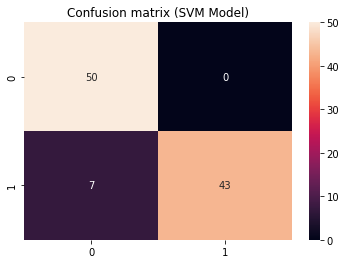

In [35]:
# Train the best XGBoost model
best_param_xgb = study_xgb.best_params
best_xgb = xgb.XGBClassifier(**best_param_xgb, use_label_encoder=False, eval_metric='logloss', random_state=123)
best_xgb.fit(x_train_, y_train)
xgb=best_xgb.fit(x_train_, y_train)
y_pred_xgb = xgb.predict(x_test_)

display_results(y_test, y_pred_xgb, cm_title = "Confusion matrix (SVM Model)")


Accuracy: 0.9300
Precision: 1.0000
Recall: 0.8600
F1 Score: 0.9247

Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        50
           1       1.00      0.86      0.92        50

    accuracy                           0.93       100
   macro avg       0.94      0.93      0.93       100
weighted avg       0.94      0.93      0.93       100



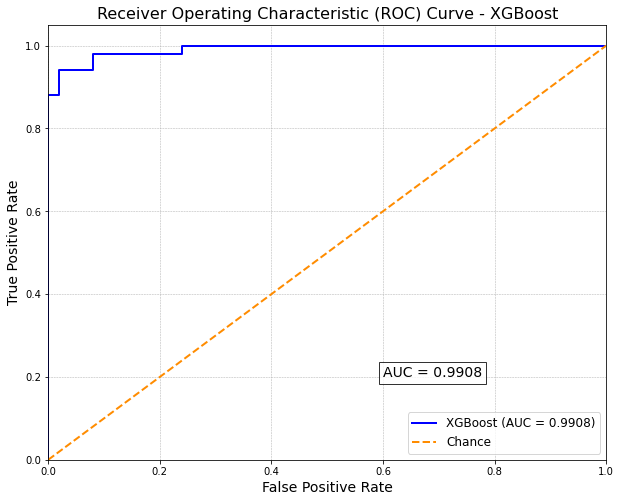

In [31]:
# Predict on the test set
y_pred_xgb = best_xgb.predict(x_test_)
y_proba_xgb = best_xgb.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Plot the ROC curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(10, 8))
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Annotate AUC directly on the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc_xgb:.4f}', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()

# 5. Models Comparison

The ROC-Curve plot provides us with a clear view to choose the best model, as it is evident that the decision tree model has the largest area under the curve. Therefore, based on the ROC , the decision tree model is selected as the best model.

In [59]:


# Create a dictionary to store the metrics for each model
metrics_summary = {
    "Model": ["KNN", "SVM", "LR", "DecT", "XGB"],
    "Accuracy": [accuracy_knn, accuracy_svm, accuracy_lr, accuracy_dect, accuracy_xgb],
    "Recall": [recall_knn, recall_svm, recall_lr, recall_dect, recall_xgb],
    "Precision": [precision_knn, precision_svm, precision_lr, precision_dect, precision_xgb],
    "F1-Score": [f1_knn, f1_svm, f1_lr, f1_dect, f1_xgb],
    "AUC": [roc_auc_lr, roc_auc_svm, roc_auc_knn, roc_auc_dect, roc_auc_xgb]
}

# Convert the dictionary into a DataFrame
metrics_df = pd.DataFrame(metrics_summary)

# Display the DataFrame
metrics_df


,Model,Accuracy,Recall,Precision,F1-Score,AUC
0,KNN,0.79,0.58,1.000000,0.734177,0.9352
1,SVM,0.81,0.62,1.000000,0.765432,0.9648
2,LR,0.61,0.24,0.923077,0.380952,0.7900
3,DecT,0.90,0.82,0.976190,0.891304,0.9252
4,XGB,0.93,0.86,1.000000,0.924731,0.9908


In [60]:
metrics_df.to_excel('result/20.xlsx', index=False)

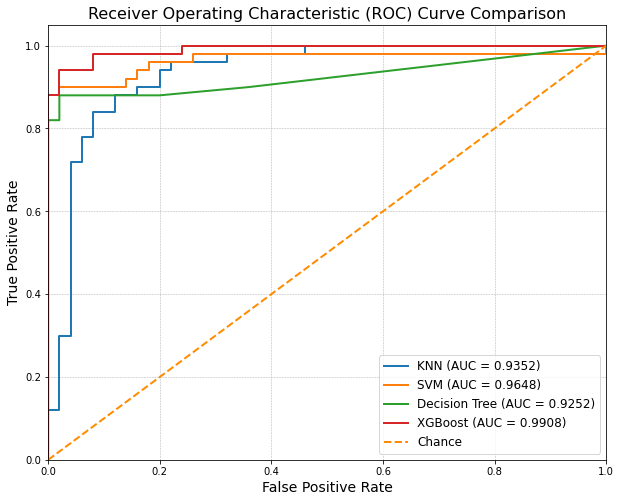

In [50]:
plt.figure(figsize=(10, 8))

# Plot ROC curve for KNN
plt.plot(fpr_lr, tpr_lr, lw=2, label=f'KNN (AUC = {roc_auc_lr:.4f})')

# Plot ROC curve for SVM
plt.plot(fpr_svm, tpr_svm, lw=2, label=f'SVM (AUC = {roc_auc_svm:.4f})')

# Plot ROC curve for Logistic Regression
#plt.plot(fpr_lr, tpr_lr, lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')

# Plot ROC curve for Decision Tree
plt.plot(fpr_dect, tpr_dect, lw=2, label=f'Decision Tree (AUC = {roc_auc_dect:.4f})')

# Plot ROC curve for XGBoost
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Show the plot
plt.show()
